Import dependencies and set initial properties



In [1]:
import tensorflow as tf
import numpy as np
import datetime, warnings, scipy
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
assert(tf.__version__, "2.5.0")

Create a constant and a tensor

In [2]:
A = tf.constant([[1,2],[3,4]])
B = tf.Variable([[1,2],[3,4]])

While concatenating tensors. check which axis to perform the join on. \\
0 - along the row \\
1 - along the column \\
...and so on

In [3]:
C = tf.concat(values=[A,B], axis=0)

Reshaping is also possible in tensorflow



In [4]:
D = tf.reshape(tensor = C, shape = [1,8])

Randomisation and initialisation via tensorflow can also be done 

In [5]:
E = tf.random.uniform(shape = [3,3])

Other operations are also possible such as reshaping, taking the transpose, dot product etc.

In [6]:
F = tf.transpose(E)
G = tf.matmul(E,F) # same as taking the dot product
H = tf.tanh(G) # taking the tanh using inbuilt math libs
I = tf.multiply(G,H) # element wise multiplication

Import the required Keras libraries 

In [7]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

Keras has three sorts of model building APIs


* **Sequential** - essentially build your network one layer at a time (left to right, top to bottom etc.)
* **Functional** - introduces a more functional, controllable approach (splitting tensors, joining tensors etc.)
* **Subclassing** - write your own subclasses into the tensor to do some external computations along the flow of the data

Complete reference available on the [official documentation](https://keras.io/api/layers/).



In [8]:
df = pd.read_csv('/content/tensorflow fundamentals/air_quality.csv', sep=' ')
df.head()

,No,Profile,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


The data is not quite ready for computation yet. There needs to be some cleaning process carried out first.

In [9]:
def combine_date(df, tab_name):
  list_tab = []
  for i in range(df.shape[0]):
    list_tab.append(df.loc[i,'Tanggal'] + 'T' + df.loc[i,tab_name][0:2])
  return np.array(list_tab, dtype='datetime64')

df['Datetime'] = combine_date(df, 'Jam')
df = df.drop(['Tanggal','Profile','No','Jam','Unnamed: 22'], axis=1)
df.head()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Datetime
0,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,2019-05-19 00:00:00
1,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,2019-05-19 00:00:00
2,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,2019-05-19 00:00:00
3,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,2019-05-19 00:00:00
4,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,2019-05-19 01:00:00


Organise the data - group by the date and hour value.

In [10]:
df2 = df.groupby(['Datetime']).mean()
df2.head()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
Datetime,,,,,,,,,,,,,,,,,
2019-05-19 00:00:00,11.797500,0.667500,15.720,9.7300,34.32175,399.135000,439.22300,0.0,0.0,0.0,7.157500,0.0,37.225000,171.850000,0.28125,3.500000,10.000000
2019-05-19 01:00:00,3.816667,0.373333,22.600,20.0900,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2019-05-19 02:00:00,6.450000,0.332500,24.130,26.3100,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,16.250000
2019-05-19 03:00:00,4.740000,0.180000,25.975,24.3900,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
2019-05-19 04:00:00,19.692500,0.202500,20.395,18.6225,53.37925,399.335000,694.23975,0.0,0.0,0.0,5.262500,0.0,53.475000,272.500000,0.18750,5.250000,13.250000


Get the basic stats and data analytics information for the table we created.

In [11]:
df2.describe()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.538909,0.233172,16.681910,12.013894,37.086256,394.616480,260.053778,0.309564,0.383692,0.451982,6.157770,0.562012,25.266942,77.634191,24.291226,7.129031,10.097848
std,3.997292,0.388102,5.373487,4.411251,12.521778,4.180224,60.773321,2.286104,2.874126,3.378291,4.149511,4.184787,6.707977,29.743129,51.993683,3.523245,5.049788
min,0.270000,0.010000,2.040000,2.162500,3.128750,380.420000,187.518000,0.000000,0.000000,0.000000,0.885000,0.000000,11.250000,26.866667,0.000000,0.000000,4.250000
25%,5.881667,0.083333,13.010000,9.015000,28.443500,391.830000,247.798333,0.000000,0.000000,0.000000,4.340000,0.000000,21.266667,57.850000,0.237500,4.666667,8.166667
50%,7.813333,0.160000,15.916667,11.730000,39.252250,394.602000,250.926250,0.000000,0.000000,0.000000,5.571667,0.000000,24.100000,77.083333,1.312500,5.833333,9.500000
75%,10.373333,0.296667,19.935000,14.595000,46.015500,397.415000,253.286667,0.000000,0.000000,0.000000,7.090000,0.000000,28.400000,94.066667,5.075000,10.500000,11.000000
max,33.741667,13.950000,99.600000,46.290000,194.554000,408.820000,1240.713500,51.600000,68.700000,79.800000,91.600000,92.900000,124.600000,313.400000,199.200000,15.000000,156.500000


Use `log` function to get the distribution of data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34d0790750>,
      dtype=object)

<Figure size 864x360 with 0 Axes>

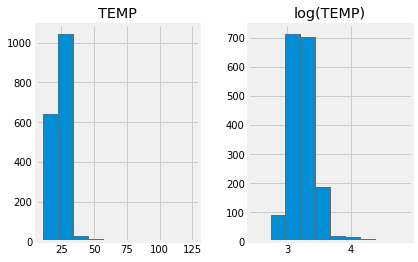

In [12]:
# log transform to deal with skewed data
dataset = np.log1p(df2[['TEMP']].values)

# create new dataframe to compare the original vs log-transformed data
dist_df = pd.DataFrame({'TEMP': df2['TEMP'].values, 'log(TEMP)': dataset[:,0]})

# create a histogram plot - original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist()

Split the dataset into test and train datasets.

In [13]:
train_size = int(len(dataset)*0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back),0]
    dataX.append(a)
    dataY.append(dataset[i+look_back, 0])
  return np.array(dataX), np.array(dataY)

# rehsape the train and test data
look_back=1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape the data in the form - [samples, time_step, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Next, we create the LSTM neural network and try to fit the data to it.

In [14]:
# create and fit the LSTM model to the data gotten

model = Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=32, verbose=2)

Epoch 1/500
41/41 - 18s - loss: 9.6983
Epoch 2/500
41/41 - 0s - loss: 8.9862
Epoch 3/500
41/41 - 0s - loss: 8.1438
Epoch 4/500
41/41 - 0s - loss: 7.1881
Epoch 5/500
41/41 - 0s - loss: 6.1658
Epoch 6/500
41/41 - 0s - loss: 5.1411
Epoch 7/500
41/41 - 0s - loss: 4.1777
Epoch 8/500
41/41 - 0s - loss: 3.3205
Epoch 9/500
41/41 - 0s - loss: 2.5906
Epoch 10/500
41/41 - 0s - loss: 1.9915
Epoch 11/500
41/41 - 0s - loss: 1.5109
Epoch 12/500
41/41 - 0s - loss: 1.1345
Epoch 13/500
41/41 - 0s - loss: 0.8435
Epoch 14/500
41/41 - 0s - loss: 0.6223
Epoch 15/500
41/41 - 0s - loss: 0.4565
Epoch 16/500
41/41 - 0s - loss: 0.3334
Epoch 17/500
41/41 - 0s - loss: 0.2437
Epoch 18/500
41/41 - 0s - loss: 0.1790
Epoch 19/500
41/41 - 0s - loss: 0.1331
Epoch 20/500
41/41 - 0s - loss: 0.1010
Epoch 21/500
41/41 - 0s - loss: 0.0789
Epoch 22/500
41/41 - 0s - loss: 0.0639
Epoch 23/500
41/41 - 0s - loss: 0.0539
Epoch 24/500
41/41 - 0s - loss: 0.0473
Epoch 25/500
41/41 - 0s - loss: 0.0431
Epoch 26/500
41/41 - 0s - loss: 0

Finally, do the predictions and check for the RMS of the train and test data.

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#invert the predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate the root mean square error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train score is %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test score is %.2f RMSE' % (testScore))

Train score is 6.72 RMSE
Test score is 4.62 RMSE
